# Method A

## A) Blahblah

#### Colab stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv

/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv


#### Libraries

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

In [ ]:
if False:
  !pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-q8piooxk
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-q8piooxk
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 958.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.7 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl siz

#### Helper functions

In [ ]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img, greyscale=False):
    if greyscale:
        # Convert images to greyscale if they aren't already
        img = img if len(img.shape) == 2 else convert_to_greyscale(img)
        gt_img = gt_img if len(gt_img.shape) == 2 else convert_to_greyscale(gt_img)
        # Ensure the images are in 8-bit unsigned integer format
        img = img.astype(np.uint8)
        gt_img = gt_img.astype(np.uint8)
        # Concatenate the greyscale images
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        nChannels = len(gt_img.shape)
        w = gt_img.shape[0]
        h = gt_img.shape[1]
        if nChannels == 3:
            cimg = np.concatenate((img, gt_img), axis=1)
        else:
            gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
            gt_img8 = img_float_to_uint8(gt_img)
            gt_img_3c[:, :, 0] = gt_img8
            gt_img_3c[:, :, 1] = gt_img8
            gt_img_3c[:, :, 2] = gt_img8
            img8 = img_float_to_uint8(img)
            cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

#### Data importation

In [ ]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 10  # Only use 10 images for training

Loading 20 images
satImage_001.png
Loading 20 images
satImage_001.png


Image size = 400,400


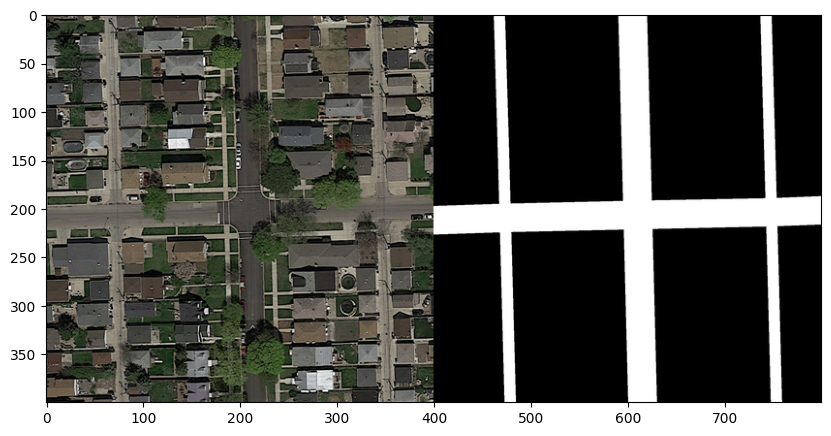

In [ ]:
#Check if importation was successful
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys")

## B) Preprocessing

#### Patch Extraction (if necessary)

In [ ]:
# Extract patches from input images
patch_size = 5  # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
gt_patches = np.asarray(
    [
        gt_patches[i][j]
        for i in range(len(gt_patches))
        for j in range(len(gt_patches[i]))
    ]
)

#### Helper functions

In [ ]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat


# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat


# Extract features for a given image
def extract_img_features(filename):
    patch_size = 5
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features_2d(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

def convert_to_greyscale(image):
    """
    Convert a loaded image to greyscale without modifying the number of pixels.

    Parameters:
    image (numpy.ndarray): The image loaded into the Python environment using mpimg.imread.

    Returns:
    numpy.ndarray: The converted greyscale image.
    """
    # Convert the image to a PIL Image object
    image_pil = Image.fromarray(image)
    # Convert the image to greyscale
    greyscale_image_pil = image_pil.convert('L')
    # Convert back to a numpy array
    greyscale_image = np.array(greyscale_image_pil)
    return greyscale_image

def preprocessing(img_list, mask = False, threshold = 50):
  img_list_conv = []
  if mask:
    for idx in range(len(img_list)):
      cimg = img_float_to_uint8(img_list[idx])
      cimg[cimg <= threshold] = 0
      cimg[cimg > threshold] = 1
      img_list_conv.append(cimg)
  else:
    for idx in range(len(img_list)):
      cimg = convert_to_greyscale(img_float_to_uint8(img_list[idx]))
      img_list_conv.append(cimg)
  return img_list_conv


#### Images to grayscale

In [ ]:
feat = convert_to_greyscale(img_float_to_uint8(imgs[0]))
feat_gt = img_float_to_uint8(gt_imgs[0])

In [ ]:
feat_gt[feat_gt > 50] = 255
feat_gt[feat_gt <= 50] = 0

In [ ]:
cimg = concatenate_images(feat, feat_gt, greyscale=True)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

## C) Various architectures

### 1) Basic CNN

#### Helper functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define the CNN architecture
class SimpleRoadSegmentationCNN(nn.Module):
  def __init__(self):
      super(SimpleRoadSegmentationCNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.output = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
      x = self.pool(torch.relu(self.conv1(x)))
      x = self.pool(torch.relu(self.conv2(x)))
      x = self.pool(torch.relu(self.conv3(x)))
      # Upsample back to the original size
      x = self.upsample(x)
      x = self.upsample(x)
      x = self.upsample(x)
      x = torch.sigmoid(self.output(x))
      return x

class RoadSegmentationDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Convert the images and masks into PIL images
        image = Image.fromarray(self.image_list[idx], mode='L')  # mode='L' for grayscale
        mask = Image.fromarray(self.mask_list[idx].astype(np.uint8) * 255, mode='L')  # Convert boolean mask to 'L'

        # Apply the transform to both the image and the mask
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # No need to add a channel dimension to mask here, since it's already handled by the transform
        return image, mask

# Define a training function
def train(model, dataloader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

from torchvision.transforms.functional import to_tensor

def predict(model, image_path, threshold = 0.5):
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((400, 400))  # Resize to the expected input size

    # Apply the same transformations as during training
    image = transforms.ToTensor()(image)

    # Add a batch dimension and send the image to the same device as the model
    image = image.unsqueeze(0)

    # Perform the prediction
    with torch.no_grad():
        prediction = model(image)

    # Apply a threshold to get a binary prediction
    thresholded_prediction = (prediction > threshold).float()

    # Convert the prediction to a NumPy array
    prediction_numpy = thresholded_prediction.cpu().numpy()

    return prediction_numpy


#### Implementation

In [ ]:
image_list = preprocessing(imgs)
mask_list = preprocessing(gt_imgs, mask=True)

In [ ]:
# Transform to convert images to PyTorch tensors and normalize if necessary
transform = transforms.Compose([
    transforms.ToTensor(),  # Automatically adds a channel dimension and converts to float32
])

# Create the dataset and dataloader
dataset = RoadSegmentationDataset(image_list, mask_list, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the model, loss, and optimizer
model = SimpleRoadSegmentationCNN()
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid and binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, dataloader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 0.8690
Epoch 2/10, Loss: 0.8316
Epoch 3/10, Loss: 0.7735
Epoch 4/10, Loss: 0.7181
Epoch 5/10, Loss: 0.6971
Epoch 6/10, Loss: 0.6937
Epoch 7/10, Loss: 0.6933
Epoch 8/10, Loss: 0.6932
Epoch 9/10, Loss: 0.6932
Epoch 10/10, Loss: 0.6932


In [ ]:
# Save the model parameters
PATH = "networks_vic/basic_CNN/"
NAME = 'road_segmentation_model.pth'
if True:
  torch.save(model.state_dict(), PATH + NAME)


### 2) Pre-trained U-Net

## D) Testing

#### Helper function

#### Prediction

In [ ]:
## Importing model

# Initialize the model
model = SimpleRoadSegmentationCNN()

# Load the model parameters
model.load_state_dict(torch.load('networks_vic/basic_CNN/road_segmentation_model.pth'))

# Set the model to evaluation mode
model.eval()

SimpleRoadSegmentationCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (output): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
# Image to test
IMAGE_PATH = 'training/images/satImage_001.png'

In [ ]:
# Predict a new image (replace 'new_image.png' with the path to your new image)
prediction = predict(model, IMAGE_PATH)

In [ ]:
np.unique(prediction[0,0,:,:])

array([0.], dtype=float32)

In [ ]:
pred = img_float_to_uint8(prediction[0,0,:,:])
# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], pred)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

<ipython-input-202-8b2bb378279f>:9: RuntimeWarning: invalid value encountered in divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)


# Method B

## Libraries & colab stuff

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv


In [2]:

!pip install segmentation-models-pytorch
!pip install pytorch-lightning==1.5.4
!pip install torchtext==0.6.0

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader, random_split


In [4]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image


In [5]:
!pip install albumentations==0.5.1

In [6]:
import albumentations as A
import albumentations.augmentations.functional as F
import cv2

In [7]:
import albumentations
print(albumentations.__version__)

0.5.1


## Data importation

In [37]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

In [39]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 100  # Only use 10 images for training

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [41]:
if False:
  # Loaded a set of images
  nbr_test = 50
  root_dir = "data/test_set_images"

  for i in range(nbr_test):
    image_dir = root_dir + "images/"
    files = os.listdir(image_dir)
    n = min(20, len(files))  # Load maximum 20 images
    print("Loading " + str(n) + " images")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]
    print(files[0])

    gt_dir = root_dir + "groundtruth/"
    print("Loading " + str(n) + " images")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
    print(files[0])

  n = 100  # Only use 10 images for training

In [42]:
for gt in gt_imgs:
  gt[gt[:,:] < 0.2] = 0
  gt[gt[:,:] >= 0.2] = 1
for img in imgs:
  img = img_float_to_uint8(img)

In [43]:
# Assume imgs and gt_imgs are lists containing your images and ground truth images respectively
# and 'n' is the number of images

dataset = []  # This will be a list of dictionaries
sub_keys = ["img", "gt"]

for i in range(n):
    # Create a dictionary for each pair of image and ground truth
    img_gt_dict = dict(zip(sub_keys, (imgs[i], gt_imgs[i])))
    # Append the dictionary to the list
    dataset.append(img_gt_dict)

In [44]:
for idx in range(len(dataset)):
  dataset[idx]["img"] = F.resize(dataset[idx]["img"], height=416, width=416)
  dataset[idx]["gt"] = F.resize(dataset[idx]["gt"], height=416, width=416)

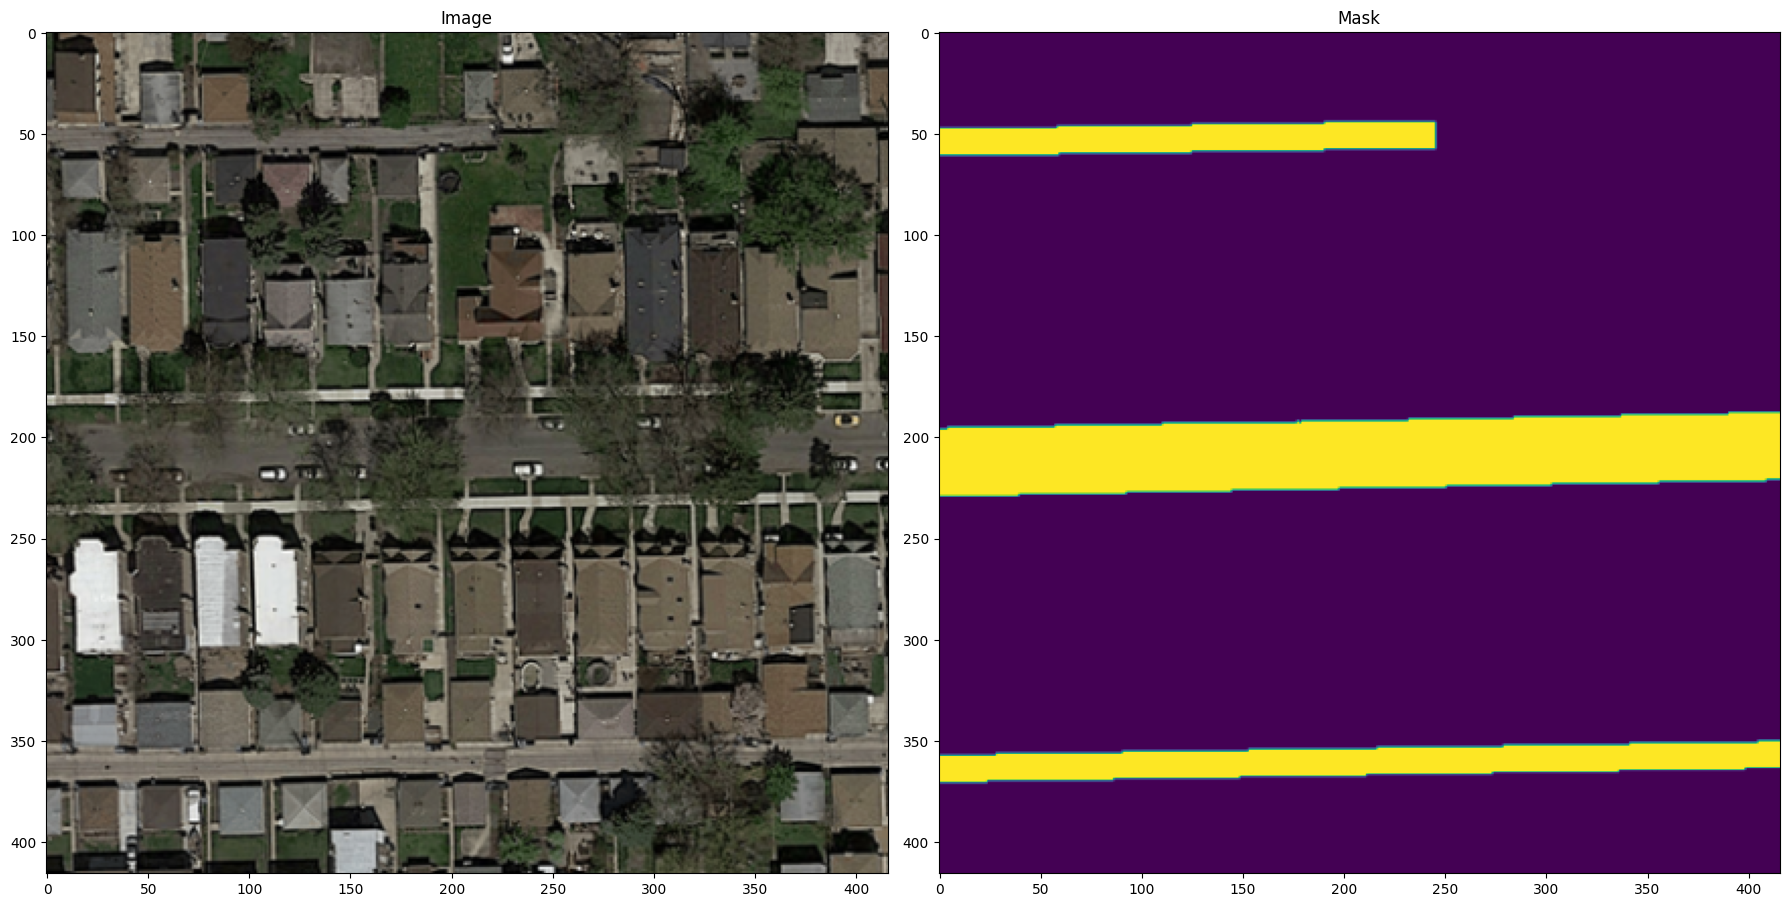

In [45]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
ax.ravel()[0].imshow(dataset[16]["img"])
ax.ravel()[0].set_title("Image")
ax.ravel()[1].imshow(dataset[16]["gt"])
ax.ravel()[1].set_title("Mask")

plt.tight_layout()
plt.show()

In [46]:
for idx in range(len(dataset)):
  dataset[idx]["img"] = dataset[idx]["img"].transpose((2, 0, 1))
  dataset[idx]["gt"] = np.expand_dims(dataset[idx]["gt"], axis=0)

In [47]:
dataset_size = len(dataset)  # Total size of the dataset
train_size = int(0.8 * dataset_size)  # 80% of the dataset
val_size = int(0.1 * dataset_size)  # 10% of the dataset
test_size = dataset_size - (train_size + val_size)  # The remaining 10% for the test

# Ensure that we have a non-negative number of samples for each set
assert train_size > 0 and val_size > 0 and test_size > 0

# Now we split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [48]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 80
Valid size: 10
Test size: 10


# Bye

## Part 2

In [59]:
class SatModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["img"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["gt"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5155317631446413).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0004792097726325445)

In [60]:
model = SatModel("FPN", "resnet34", in_channels=3, out_classes=1)

## Training

In [61]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Validation and test metrics

In [62]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.5896435976028442,
  'valid_per_image_iou': 0.5785739421844482}]


In [63]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.5588697195053101,
  'test_per_image_iou': 0.5478984713554382}]


In [64]:
test_metrics[0]["test_dataset_iou"]

0.5588697195053101

## Result vizualization

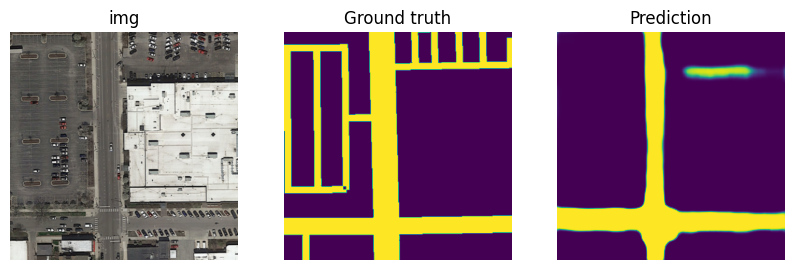

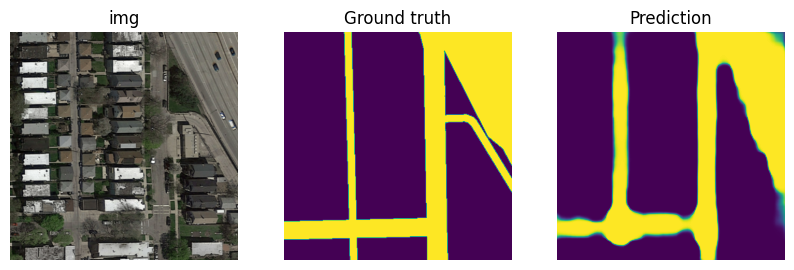

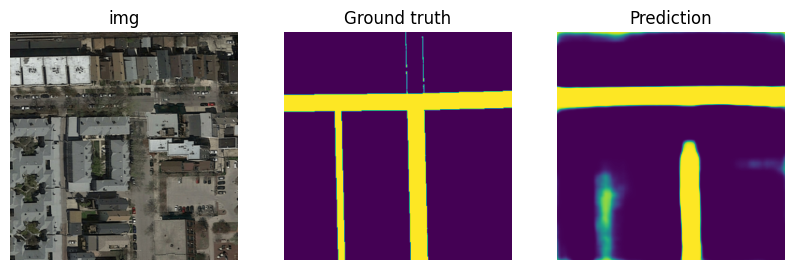

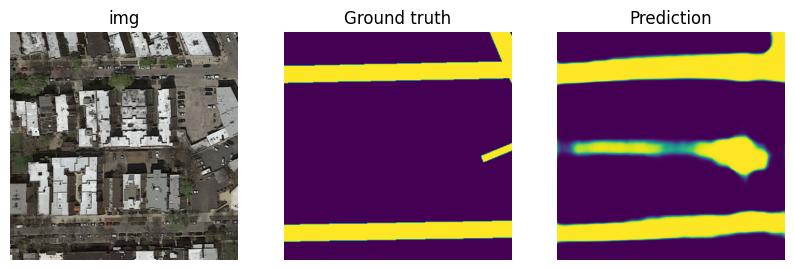

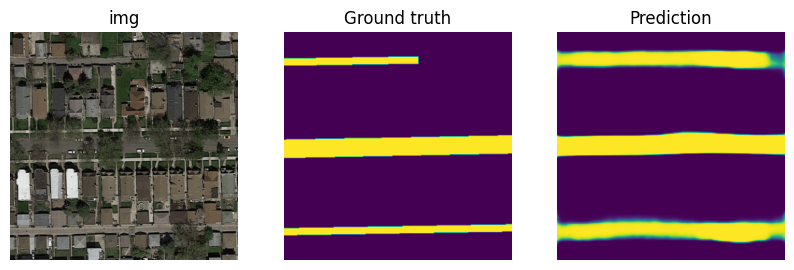

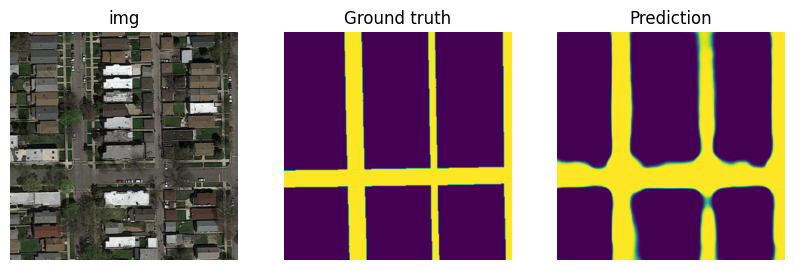

In [65]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["img"])
pr_gts = logits.sigmoid()

for img, gt_gt, pr_gt in zip(batch["img"], batch["gt"], pr_gts):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("img")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_gt.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_gt.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

# Optimization

In [ ]:
!pip install bayesian-optimization

In [49]:
from bayes_opt import BayesianOptimization
import gc


Values to consider as interesting parameters:
- learning rate lr
- prediction mask probability msk_prob

In [50]:
class SatModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, opti_arguments, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # values of arguments to optimize
        self.learning_rate = opti_arguments["learning_rate"]
        self.mask_prob = opti_arguments["mask_prob"]

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):

        image = batch["img"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["gt"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > self.mask_prob).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [51]:
def train_and_evaluate(learning_rate, mask_prob):
    # Instantiate the model with the given parameters
    opti_arguments = {"learning_rate": learning_rate, "mask_prob": learning_rate}
    model = SatModel("FPN", "resnet34", in_channels=3, out_classes=1, opti_arguments=opti_arguments)

    # Train the model
    trainer = pl.Trainer(
              gpus=1,
              max_epochs=5,
    );

    trainer.fit(
        model,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
    );

    # Evaluate the model to get your performance metric
    test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False);

    metric_to_optimize = test_metrics[0]["test_dataset_iou"]

    # Clean up model from memory
    del model
    gc.collect()  # Explicitly call garbage collection
    torch.cuda.empty_cache()  # Clear cache if using CUDA

    return metric_to_optimize


In [52]:
# Define the bounds of the hyperparameters you want to optimize.
# For instance, 'param1' and 'param2' could represent sizes of layers, learning rates, etc.
pbounds = {
    'learning_rate': (1e-6, 1e-3),  # Example range for param1
    'mask_prob': (0.3, 0.7)  # Example range for param2
}

# Instantiate Bayesian Optimization
optimizer = BayesianOptimization(
    f=train_and_evaluate,
    pbounds=pbounds,
    random_state=1,
)

# Run optimization. Here, 'init_points' is the number of different random sets
# of hyperparameters to try before the Bayesian optimization kicks in. 'n_iter' is
# the number of iterations of Bayesian optimization to perform.
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

# The 'max' property of the optimizer object will tell you the best hyperparameter set found
# as well as the associated metric value.
print(optimizer.max)

|   iter    |  target   | learni... | mask_prob |
-------------------------------------------------


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 1         | 0.4962    | 0.0004176 | 0.5881    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 2         | 0.2125    | 1.114e-06 | 0.4209    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 3         | 0.4253    | 0.0001476 | 0.3369    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 4         | 0.4627    | 0.0001871 | 0.4382    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 5         | 0.4435    | 0.0003974 | 0.5155    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 6         | 0.3504    | 8.715e-05 | 0.337     |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 7         | 0.4269    | 0.0002219 | 0.4382    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 8         | 0.4241    | 0.0004474 | 0.5883    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 9         | 0.4908    | 0.0002542 | 0.4381    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 10        | 0.3714    | 0.0004187 | 0.5881    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 11        | 0.4484    | 0.0001468 | 0.337     |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 12        | 0.4266    | 0.0001358 | 0.337     |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 13        | 0.402     | 0.0001435 | 0.4382    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 14        | 0.5125    | 0.0004792 | 0.5155    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 15        | 0.2125    | 0.0004981 | 0.5156    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 16        | 0.4443    | 0.0004189 | 0.5155    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 17        | 0.4669    | 0.0002352 | 0.4383    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 18        | 0.4002    | 0.0004448 | 0.5882    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 19        | 0.4509    | 0.0002494 | 0.4381    |


INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

| 20        | 0.3795    | 0.0001088 | 0.3369    |
{'target': 0.5125154256820679, 'params': {'learning_rate': 0.0004792097726325445, 'mask_prob': 0.5155317631446413}}


In [58]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.4962196350097656, 'params': {'learning_rate': 0.0004176049826978715, 'mask_prob': 0.5881297973768632}}
Iteration 1: 
	{'target': 0.21248728036880493, 'params': {'learning_rate': 1.1142604425275418e-06, 'mask_prob': 0.4209330290527359}}
Iteration 2: 
	{'target': 0.42530640959739685, 'params': {'learning_rate': 0.00014760913492629596, 'mask_prob': 0.3369354379075191}}
Iteration 3: 
	{'target': 0.46265754103660583, 'params': {'learning_rate': 0.00018707395116629325, 'mask_prob': 0.4382242908172191}}
Iteration 4: 
	{'target': 0.44351762533187866, 'params': {'learning_rate': 0.0003973707067564393, 'mask_prob': 0.5155266936013427}}
Iteration 5: 
	{'target': 0.35036617517471313, 'params': {'learning_rate': 8.714510083931457e-05, 'mask_prob': 0.3369724452619328}}
Iteration 6: 
	{'target': 0.42686042189598083, 'params': {'learning_rate': 0.00022190572540932435, 'mask_prob': 0.43815727388778525}}
Iteration 7: 
	{'target': 0.42406293749809265, 'params': {'learning_rate

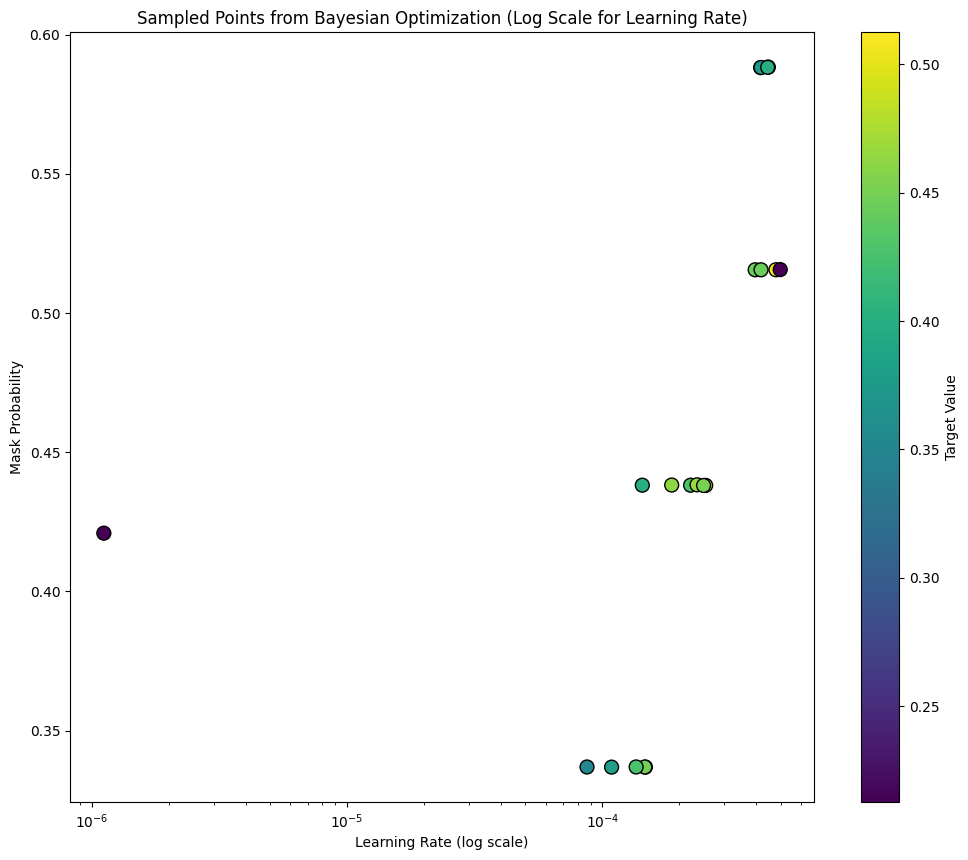

In [66]:
# We will plot the sampled points again, this time with a logarithmic x-axis for the learning rate.

plt.figure(figsize=(12, 10))

# Scatter plot of sampled points with the target value as the color
# Note that we use a logarithmic scale for the x-axis (learning rate)
plt.scatter(learning_rates, mask_probs, c=targets, cmap='viridis', s=100, edgecolors='k')
plt.xscale('log')

# Add color bar to show the mapping from color to the target value
cbar = plt.colorbar()
cbar.set_label('Target Value')

# Label the axes
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Mask Probability')
plt.title('Sampled Points from Bayesian Optimization (Log Scale for Learning Rate)')

# Show the plot
plt.show()